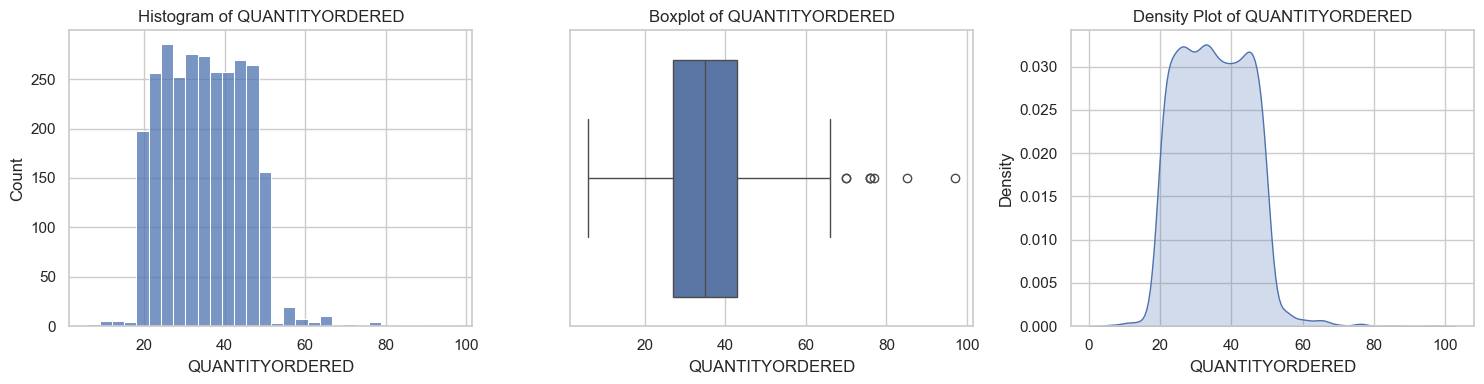

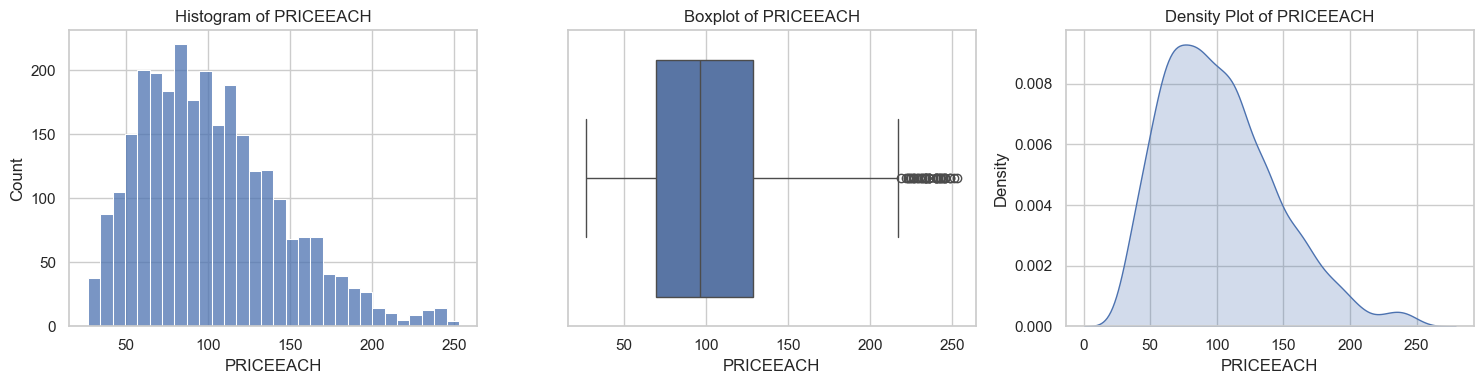

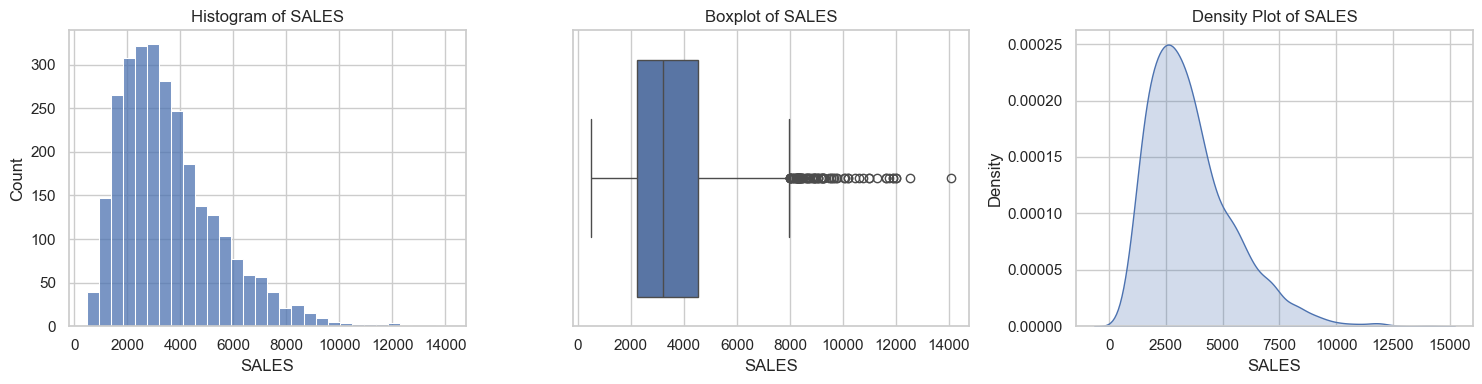

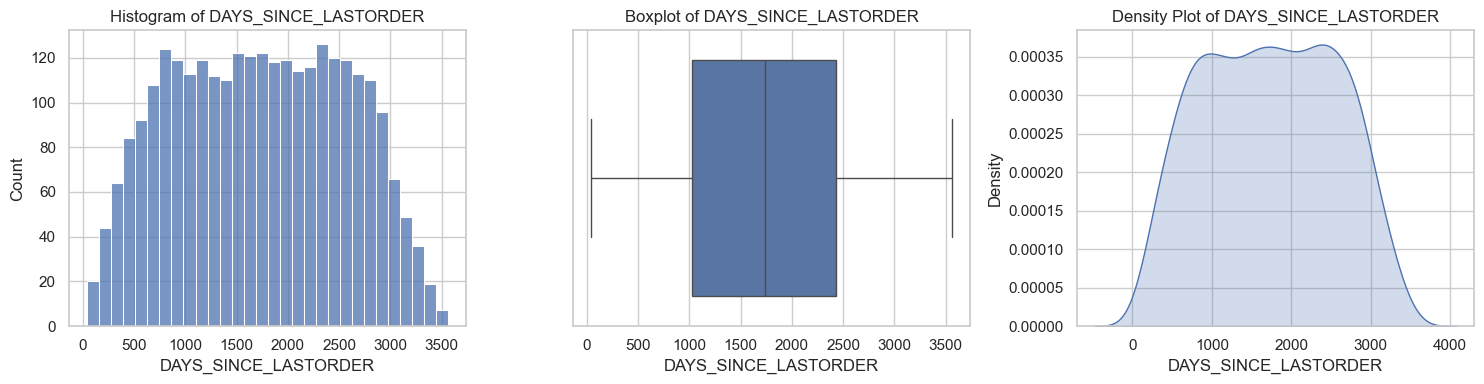

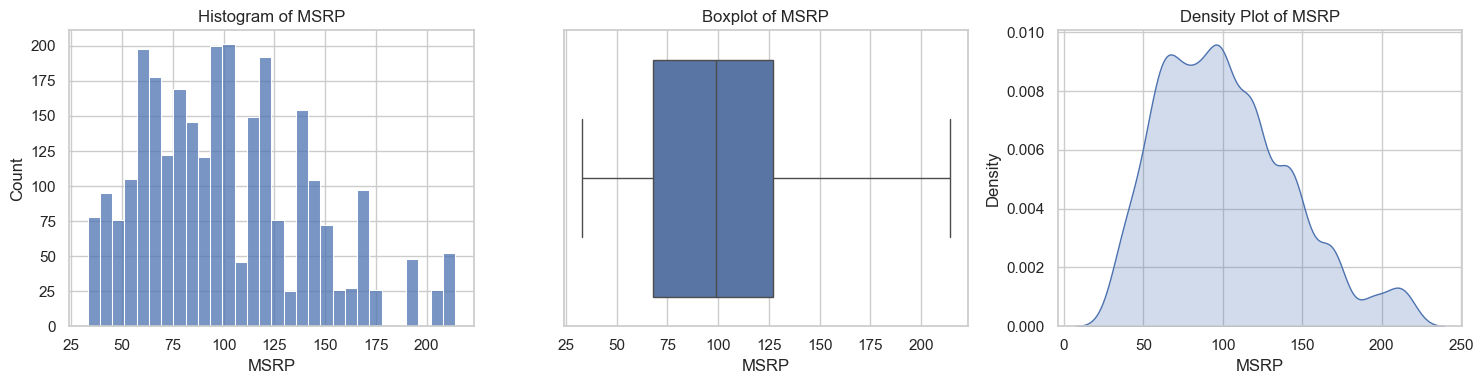

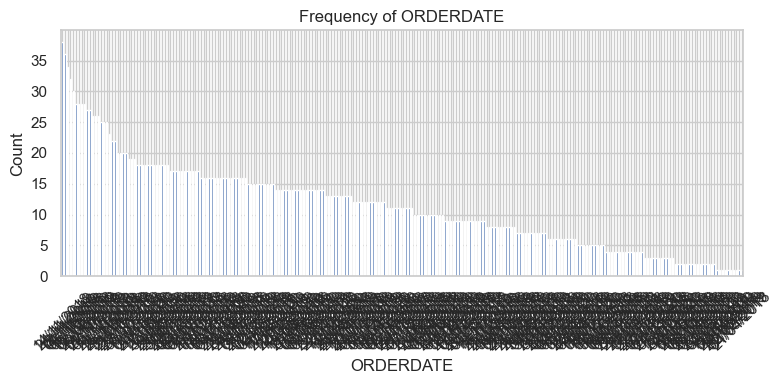

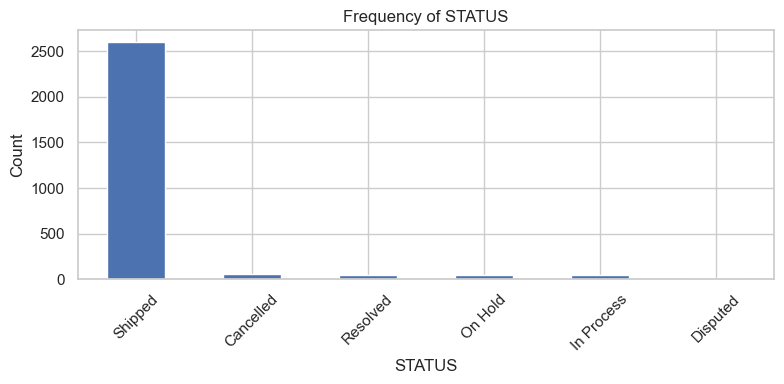

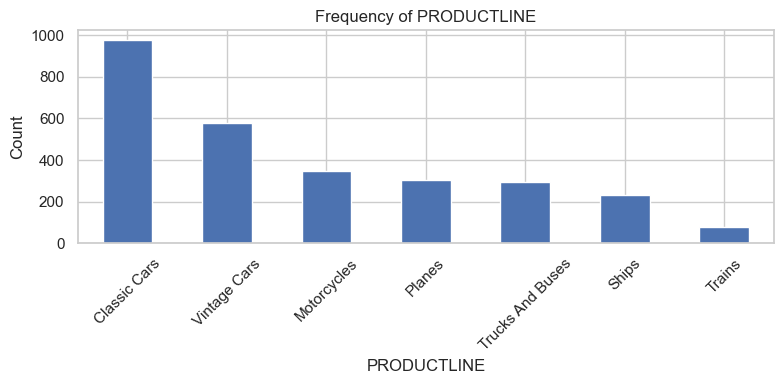

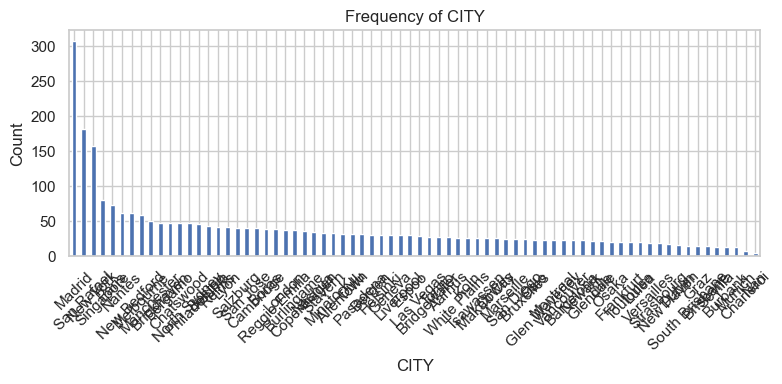

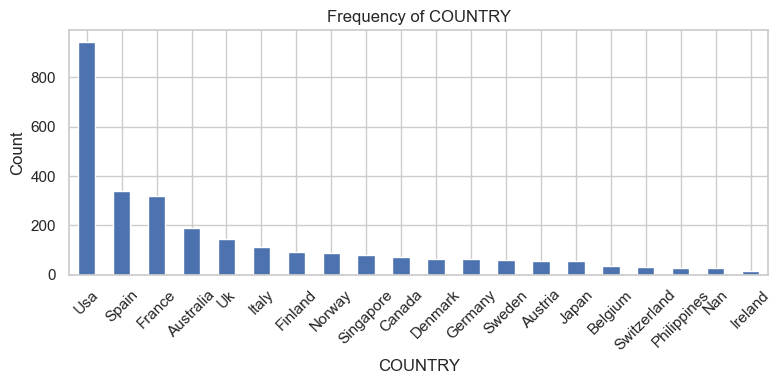

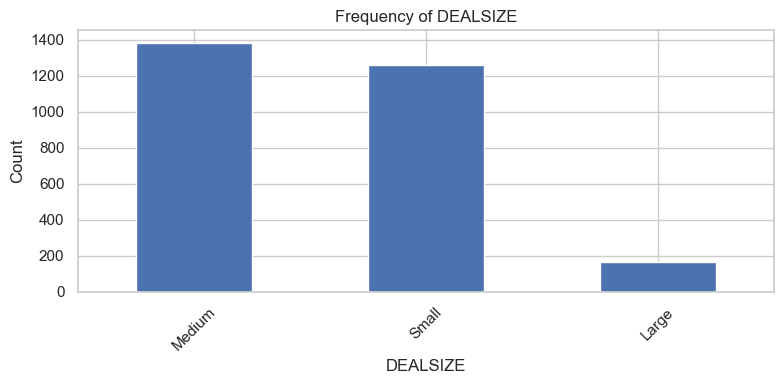

Outlier Detection Summary:

QUANTITYORDERED: 8 outliers detected
PRICEEACH: 42 outliers detected
SALES: 82 outliers detected
DAYS_SINCE_LASTORDER: 0 outliers detected
MSRP: 0 outliers detected


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV file
df = pd.read_csv(r"C:\Users\saad_\OneDrive\Desktop\BI\cleaneddatafinaltosend.csv")  # Replace with your actual path

# Drop specified columns
cols_to_drop = ['ORDERNUMBER', 'ORDERLINENUMBER', 'PHONE', 'POSTALCODE1', 'POSTALCODE2',
                'PRODUCTCODE', 'CUSTOMERNAME', 'ADDRESSLINE1', 'ADDRESSLINE2',
                'CONTACTLASTNAME', 'CONTACTFIRSTNAME', 'CONTACTNAME']

df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])


# Auto-detect column types
numerical_cols = df.select_dtypes(include='number').columns
categorical_cols = df.select_dtypes(include='object').columns

# Set plot style
sns.set(style='whitegrid')

# a. Histograms, Boxplots, Density Plots for Numerical Columns
for col in numerical_cols:
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    sns.histplot(df[col].dropna(), kde=False, bins=30)
    plt.title(f'Histogram of {col}')

    plt.subplot(1, 3, 2)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')

    plt.subplot(1, 3, 3)
    sns.kdeplot(df[col].dropna(), fill=True)
    plt.title(f'Density Plot of {col}')

    plt.tight_layout()
    plt.show()

# b. Frequency Histograms of Important Categorical Columns
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Frequency of {col}')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# c. Outlier Detection (IQR method) and Anomaly Detection
print("Outlier Detection Summary:\n")
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    count_outliers = outliers.shape[0]
    print(f"{col}: {count_outliers} outliers detected")


QUANTITYORDERED (int64): Positively skewed with some high-value outliers (up to 100). Most values fall between 20–60, and the median is around 35.

PRICEEACH (float64): Right-skewed with positive kurtosis. Median is approximately 97. Many products are priced in the upper quartile range.

SALES (float64): Heavily positively skewed with high kurtosis, suggesting a few very large sales. The average is around 3000, but some orders exceed 13,000.

DAYS_SINCE_LASTORDER (float64): Appears symmetrically distributed with low kurtosis. The median is around 1750, though values are broadly spread.

STATUS (object): Most orders are marked as "Delivered", which is a positive sign. A few are "On Hold" or "In Process", which may need attention.

PRODUCTLINE (object): The most frequently ordered products fall under "Cars", while "Ships" and "Trains" are least ordered, possibly indicating customer preference or usage trends.

MSRP (int64): Distribution is positively skewed with a median of 99. The absence of outliers suggests consistent pricing across products.

CITY (object): Madrid has the highest number of orders, while Charleroi has the least. However, total revenue by city may vary independently of order count.

COUNTRY (object): USA leads in order volume, while Ireland has the fewest.

DEALSIZE (object): Most deals are "Medium", followed by "Small". "Large" deals are relatively rare, indicating medium average deal volumes.

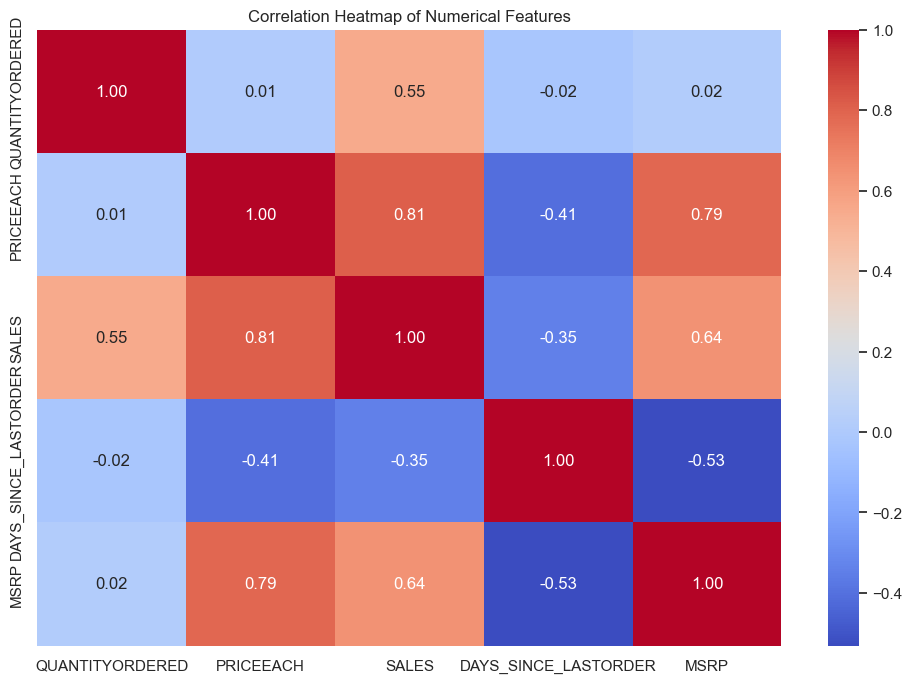


ANOVA for STATUS vs SALES
                      sum_sq      df         F   PR(>F)
C(Q("STATUS"))  6.993884e+07     5.0  4.027149  0.00121
Residual        9.708061e+09  2795.0       NaN      NaN
Tukey HSD Results:
        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
  group1     group2    meandiff  p-adj    lower      upper   reject
-------------------------------------------------------------------
 Cancelled   Disputed  2073.8047 0.0017   539.5882 3608.0212   True
 Cancelled In Process   490.2315 0.7811  -579.0131 1559.4762  False
 Cancelled    On Hold   826.2509 0.2226  -228.6022 1881.1039  False
 Cancelled   Resolved   -34.6861    1.0 -1069.9346 1000.5624  False
 Cancelled    Shipped   338.2964 0.7331  -355.7189 1032.3116  False
  Disputed In Process -1583.5731 0.0539 -3182.1901   15.0438  False
  Disputed    On Hold -1247.5538 0.2203 -2836.5809  341.4733  False
  Disputed   Resolved -2108.4908 0.0019 -3684.5718 -532.4097   True
  Disputed    Shipped -1735.5083 0.004

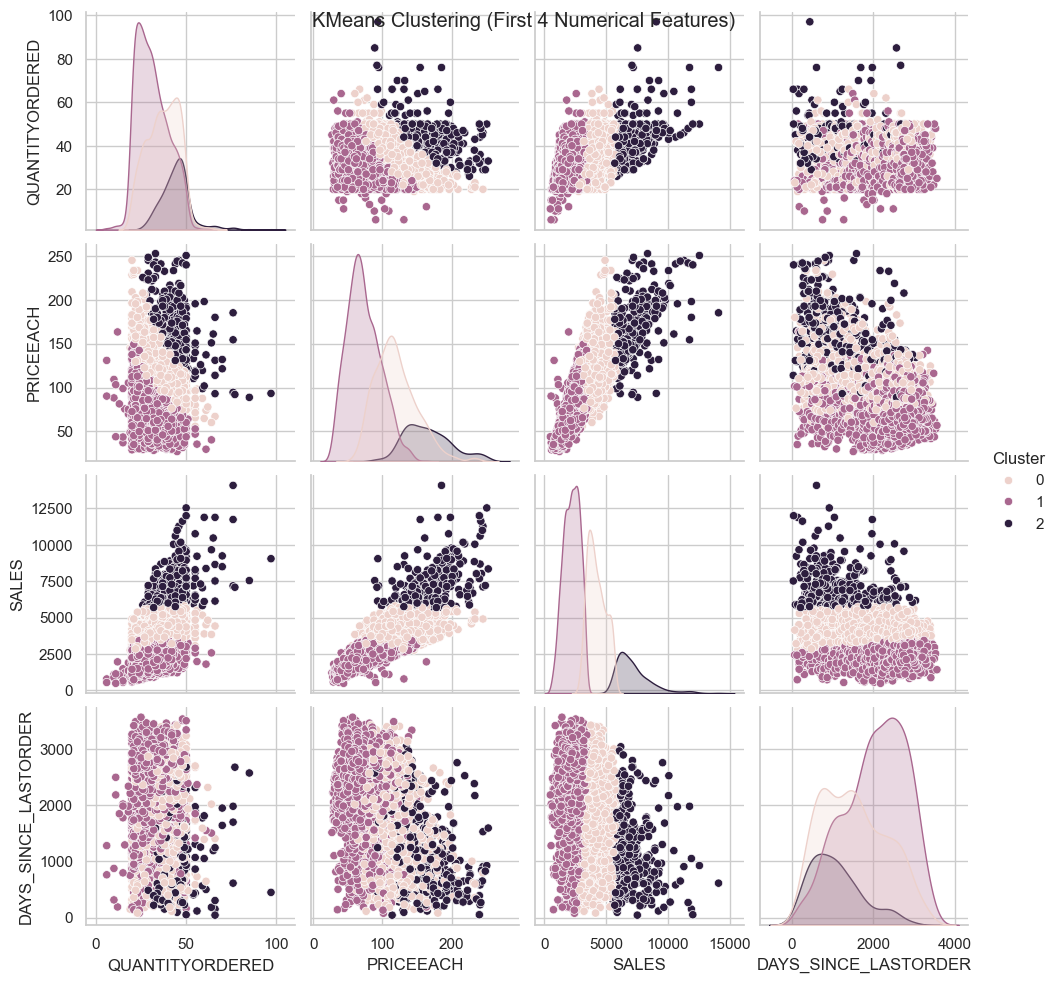


Linear Regression Coefficients:
QUANTITYORDERED: 103.42
PRICEEACH: 35.20
DAYS_SINCE_LASTORDER: -0.02
MSRP: -0.31
Intercept: -3577.49
R-squared: 0.95


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, chi2_contingency
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from patsy import dmatrix, ModelDesc, Term, EvalFactor

# Drop specified columns
cols_to_drop = ['ORDERDATE']
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])
df = df.dropna()


# Identify columns
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(include='object').columns

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

# ANOVA and Tukey for each categorical column vs SALES
target = 'SALES'
for col in cat_cols:
    if df[col].nunique() > 1 and not df[col].isnull().any():
        print(f"\nANOVA for {col} vs {target}")
        formula = f'{target} ~ C(Q("{col}"))'
        model = ols(formula, data=df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print(anova_table)

        # Tukey HSD
        try:
            tukey = pairwise_tukeyhsd(df[target], df[col])
            print("Tukey HSD Results:")
            print(tukey)
        except:
            print("Tukey test failed. Possibly due to insufficient group sizes.")

# T-test for binary categorical features
for col in cat_cols:
    if df[col].nunique() == 2:
        groups = df[col].unique()
        group1 = df[df[col] == groups[0]][target]
        group2 = df[df[col] == groups[1]][target]
        stat, p = ttest_ind(group1, group2)
        print(f"\nT-test for {col}: p-value = {p:.4f}")
        if p < 0.05:
            print("Significant difference found.")
        else:
            print("No significant difference.")

# Chi-square test for categorical vs categorical
print("\nChi-Squared Tests for Categorical Columns")
for i in range(len(cat_cols)):
    for j in range(i+1, len(cat_cols)):
        table = pd.crosstab(df[cat_cols[i]], df[cat_cols[j]])
        chi2, p, dof, ex = chi2_contingency(table)
        print(f"{cat_cols[i]} vs {cat_cols[j]}: p-value = {p:.4f}")
        if p < 0.05:
            print(" -> Significant association")
        else:
            print(" -> No significant association")

# Clustering (optional)
df_cluster = df[num_cols].dropna()
kmeans = KMeans(n_clusters=3, random_state=0).fit(df_cluster)
df['Cluster'] = kmeans.labels_
sns.pairplot(df, hue='Cluster', vars=num_cols[:4])
plt.suptitle("KMeans Clustering (First 4 Numerical Features)")
plt.show()

# Regression (optional)
reg_df = df[num_cols].dropna()
X = reg_df.drop(columns=[target])
y = reg_df[target]
lr = LinearRegression().fit(X, y)
print("\nLinear Regression Coefficients:")
for feature, coef in zip(X.columns, lr.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept: {lr.intercept_:.2f}")
print(f"R-squared: {lr.score(X, y):.2f}")


ANOVA for STATUS vs SALES:
A significant difference exists between statuses (p-value = 0.00121), indicating status impacts sales.

Tukey HSD shows significant differences between Cancelled vs Disputed (p = 0.0017) and Disputed vs Resolved (p = 0.0019).

ANOVA for PRODUCTLINE vs SALES:
A significant difference exists between product lines (p-value = 3.47e-33), meaning product line impacts sales.

Tukey HSD shows significant differences for Classic Cars vs Motorcycles (p = 0.0) and Classic Cars vs Planes (p = 0.0).

ANOVA for CITY vs SALES:
No significant effect of city on sales (p-value = 0.163963), indicating city doesn't impact sales.

ANOVA for COUNTRY vs SALES:
No significant effect of country on sales (p-value = 0.796359), and no significant pairwise differences between countries.

Summary:
STATUS and PRODUCTLINE show significant effects on sales, while CITY and COUNTRY do not.

ANOVA for DEALSIZE vs SALES:
A significant difference in sales between deal sizes (p-value = 0.0), indicating deal size impacts sales.

Tukey HSD for DEALSIZE:
Large deals have significantly higher sales than Medium and Small.

Medium deals have higher sales than Small deals, with all differences being statistically significant.

Chi-Squared Tests for Categorical Columns:
STATUS vs PRODUCTLINE: p-value = 0.0000, indicating a significant association between status and product line.

STATUS vs CITY: p-value = 0.0000, indicating a significant association between status and city.

STATUS vs COUNTRY: p-value = 0.0000, indicating a significant association between status and country.

STATUS vs DEALSIZE: p-value = 0.0000, indicating a significant association between status and deal size.

PRODUCTLINE vs CITY: p-value = 0.0000, indicating a significant association between product line and city.

PRODUCTLINE vs COUNTRY: p-value = 0.0000, indicating a significant association between product line and country.

PRODUCTLINE vs DEALSIZE: p-value = 0.0000, indicating a significant association between product line and deal size.

CITY vs COUNTRY: p-value = 0.0000, indicating a significant association between city and country.

CITY vs DEALSIZE: p-value = 0.3135, indicating no significant association between city and deal size.

COUNTRY vs DEALSIZE: p-value = 0.3500, indicating no significant association between country and deal size.
